A notebook for finetuning Stable Diffusion using LORA.

Tested with [Stable Diffusion v1-5](https://huggingface.co/runwayml/stable-diffusion-v1-5).

Notebook developed by [pedrogengo](https://github.com/pedrogengo).

# SETUP

In [1]:
!git clone https://github.com/cloneofsimo/lora.git && sed -i 's/functools.cache/functools.lru_cache(maxsize=None)/g' /content/lora/lora_diffusion/xformers_utils.py && pip install /content/lora
!pip install accelerate bitsandbytes

Cloning into 'lora'...
remote: Enumerating objects: 934, done.
remote: Counting objects: 100% (407/407), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 934 (delta 346), reused 301 (delta 301), pack-reused 527
Receiving objects: 100% (934/934), 182.96 MiB | 26.97 MiB/s, done.
Resolving deltas: 100% (560/560), done.
Updating files: 100% (60/60), done.
Processing ./lora
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 989.1/989.1 kB 3.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 96.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 13.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 73.7 MB/s e

In [2]:
# for greater reliability

import torch
import torch.nn as nn
import numpy as np
import random

torch.manual_seed(123)
torch.cuda.manual_seed(123)
np.random.seed(123)
random.seed(123)
torch.backends.cudnn.enabled=False
torch.backends.cudnn.deterministic=True

# TRAINING

In [3]:
import os
import shutil
from google.colab import files
from tqdm import tqdm

PRETRAINED_MODEL="runwayml/stable-diffusion-v1-5" #@param{type: 'string'}
PROMPT="ktn" #@param{type: 'string'}

OUTPUT_DIR="" #@param{type: 'string'}
IMAGES_FOLDER_OPTIONAL="/content/imgs" #@param{type: 'string'}

RESOLUTION="512" #@param ["512", "576", "640", "704", "768", "832", "896", "960", "1024"]
RESOLUTION=int(RESOLUTION)

if PRETRAINED_MODEL == "":
  print('[1;31mYou should define the pretrained model.')

else:
  if IMAGES_FOLDER_OPTIONAL=="":
    INSTANCE_DIR = "/content/data_example"
    if not os.path.exists(str(INSTANCE_DIR)):
      %mkdir -p "$INSTANCE_DIR"
    uploaded = files.upload()
    for filename in tqdm(uploaded.keys(), bar_format='  |{bar:15}| {n_fmt}/{total_fmt} Uploaded'):
        shutil.move(filename, INSTANCE_DIR)
  else:
    INSTANCE_DIR = IMAGES_FOLDER_OPTIONAL

  if OUTPUT_DIR == "":
    OUTPUT_DIR = "/content/output"
  if not os.path.exists(str(OUTPUT_DIR)):
    %mkdir -p "$OUTPUT_DIR"

In [ ]:
# change manually the 493rd line in  /content/lora/training_scripts/train_lora_dreambooth.py

# from this: 'logging_dir=logging_dir,' to this 'project_dir=logging_dir,'

# bc of:
# https://github.com/cloneofsimo/lora/pull/256 and
# https://github.com/huggingface/accelerate/issues/1550?ysclid=llvzm7qt8g15639166

In [4]:
STEPS = 5000 #@param {type:"slider", min:0, max:10000, step:10}
BATCH_SIZE = 1 #@param {type:"slider", min:0, max:128, step:1}
FP_16 = True #@param {type:"boolean"}

#@markdown ----
#@markdown UNET PARAMS
LEARNING_RATE = 1e-4 #@param {type:"number"}

#@markdown ----
TRAIN_TEXT_ENCODER = True #@param {type:"boolean"}
#@markdown TEXT ENCODER PARAMS
LEARNING_RATE_TEXT_ENCODER = 1e-5 #@param {type:"number"}

NEW_LEARNING_RATE = LEARNING_RATE / BATCH_SIZE
NEW_LEARNING_RATE_TEXT_ENCODER = LEARNING_RATE_TEXT_ENCODER / BATCH_SIZE

if FP_16:
  fp_16_arg = "fp16"
else:
  fp_16_arg = "no"

if TRAIN_TEXT_ENCODER:
  command = (f'accelerate launch lora/training_scripts/train_lora_dreambooth.py '
             f'--pretrained_model_name_or_path="{PRETRAINED_MODEL}" '
             f'--instance_data_dir="{INSTANCE_DIR}" '
             f'--output_dir="{OUTPUT_DIR}" '
             f'--instance_prompt="{PROMPT}" '
             f'--resolution=512 '
             f'--use_8bit_adam '
             f'--mixed_precision="{fp_16_arg}" '
             f'--train_batch_size=1 '
             f'--gradient_accumulation_steps=1 '
             f'--learning_rate={NEW_LEARNING_RATE} '
             f'--lr_scheduler="constant" '
             f'--lr_warmup_steps=0 '
             f'--max_train_steps={STEPS} '
             f'--train_text_encoder '
             f'--lora_rank=16 '
             f'--seed=123 '
             f'--learning_rate_text={NEW_LEARNING_RATE_TEXT_ENCODER}')
else:
  command = (f'accelerate launch lora/training_scripts/train_lora_dreambooth.py '
             f'--pretrained_model_name_or_path="{PRETRAINED_MODEL}" '
             f'--instance_data_dir="{INSTANCE_DIR}" '
             f'--output_dir="{OUTPUT_DIR}" '
             f'--instance_prompt="{PROMPT}" '
             f'--resolution=512 '
             f'--use_8bit_adam '
             f'--mixed_precision="{fp_16_arg}" '
             f'--train_batch_size=1 '
             f'--gradient_accumulation_steps=1 '
             f'--learning_rate={NEW_LEARNING_RATE} '
             f'--lr_scheduler="constant" '
             f'--lr_warmup_steps=0 '
             f'--lora_rank=16 '
             f'--max_train_steps={STEPS} '
             f'--learning_rate_text={NEW_LEARNING_RATE_TEXT_ENCODER}')
!rm -rf $INSTANCE_DIR/.ipynb_checkpoints
!{command}

2023-09-04 19:06:57.898697: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_processes` was set to a value of `1`
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
2023-09-04 19:07:04.756635: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Before training: Unet First Layer lora up tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
Before training: Unet First Layer lora down tensor([[ 0.0247,  0.0048,  0

# INFERENCE

In [5]:
#@title LOADING MODEL AND MONKEY PATCHING IT
import torch
from lora_diffusion import monkeypatch_or_replace_lora, tune_lora_scale
from diffusers import StableDiffusionPipeline


pipe = StableDiffusionPipeline.from_pretrained(PRETRAINED_MODEL, torch_dtype=torch.float16).to("cuda")
monkeypatch_or_replace_lora(pipe.unet, torch.load(os.path.join(OUTPUT_DIR, "lora_weight.pt")))
monkeypatch_or_replace_lora(pipe.text_encoder, torch.load(os.path.join(OUTPUT_DIR, "lora_weight.text_encoder.pt")), target_replace_module=["CLIPAttention"])

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [6]:
pipe.safety_checker = None

  0%|          | 0/50 [00:00<?, ?it/s]

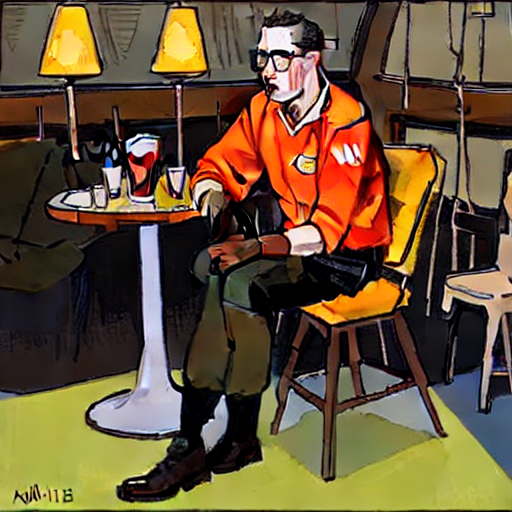

In [41]:
# @title For one image inference
INFERENCE_PROMPT = 'A ktn is sitting in the pub' #@param {type:"string"}
LORA_SCALE_UNET = 1 #@param {type:"number"}
LORA_SCALE_TEXT_ENCODER = 1 #@param {type:"number"}
GUIDANCE = 9 #@param {type:"slider", min:0, max:15, step:0.2}


tune_lora_scale(pipe.unet, LORA_SCALE_UNET)
if TRAIN_TEXT_ENCODER:
    tune_lora_scale(pipe.text_encoder, LORA_SCALE_TEXT_ENCODER)

image = pipe(INFERENCE_PROMPT, num_inference_steps=50, guidance_scale=GUIDANCE).images[0]
# image.save(f"gen_imgs/sp_{LORA_SCALE_UNET};{LORA_SCALE_TEXT_ENCODER};{GUIDANCE}.png")
image

In [7]:
# @title For multiple images inference
from tqdm.auto import tqdm


dpr = {'A ktn is smiling': 'sf', 'A ktn is falling from the cliff': 'fc', 'A ktn is sitting in the pub': 'sp'}
for INFERENCE_PROMPT in tqdm(['A ktn is smiling', 'A ktn is falling from the cliff', 'A ktn is sitting in the pub'], desc="Promts"):
    pr = dpr[INFERENCE_PROMPT]
    for GUIDANCE in tqdm([3], desc="Guidance"):
        for LORA_SCALE_UNET in tqdm(np.arange(0, 1.2, 0.2), desc="UNET"):
            for LORA_SCALE_TEXT_ENCODER in tqdm(np.arange(0, 1.2, 0.2), desc="Text Encoder"):

                tune_lora_scale(pipe.unet, LORA_SCALE_UNET)
                if TRAIN_TEXT_ENCODER:
                    tune_lora_scale(pipe.text_encoder, LORA_SCALE_TEXT_ENCODER)

                # clear_output(wait=True)

                image = pipe(INFERENCE_PROMPT, num_inference_steps=50, guidance_scale=GUIDANCE).images[0]
                image.save(f"gen_imgs/{pr}_{LORA_SCALE_UNET};{LORA_SCALE_TEXT_ENCODER};{GUIDANCE}.png")

                # plt.imshow(img)
                # plt.axis('off')
                # plt.show()


Promts:   0%|          | 0/3 [00:00<?, ?it/s]

Guidance:   0%|          | 0/1 [00:00<?, ?it/s]

UNET:   0%|          | 0/6 [00:00<?, ?it/s]

Text Encoder:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Text Encoder:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Text Encoder:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Text Encoder:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Text Encoder:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Text Encoder:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Guidance:   0%|          | 0/1 [00:00<?, ?it/s]

UNET:   0%|          | 0/6 [00:00<?, ?it/s]

Text Encoder:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Text Encoder:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Text Encoder:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Text Encoder:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Text Encoder:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Text Encoder:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Guidance:   0%|          | 0/1 [00:00<?, ?it/s]

UNET:   0%|          | 0/6 [00:00<?, ?it/s]

Text Encoder:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Text Encoder:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Text Encoder:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Text Encoder:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Text Encoder:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Text Encoder:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [8]:
# to convert folder to zip in order to save it

import zipfile
import os

save_dir = 'gen_imgs'

with zipfile.ZipFile('gen_imgs.zip', 'w') as zipf:
    for root, _, files in os.walk(save_dir):
        for file in files:
            zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), save_dir))

print('Images zipped successfully.')


Images zipped successfully.


In [9]:
# from this: https://github.com/cloneofsimo/lora/discussions/37#discussioncomment-4426998

from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import PIL
import pathlib
import os
import math
import matplotlib.pyplot as plt


def plot_img_grid(image_list, image_size=64, num_cols=4, fig_name="", col_names=[], row_names=[], dpi=96):
    """
    display a list of images (either np or PIL) as a grid, with optional figure title and row/column titles
    will resize images to desired (assumes square)
    """
    # prepare inputs
    num_rows = math.ceil(len(image_list) / num_cols)
    # in case different number of titles than grid size allows:
    if len(col_names) != num_cols and col_names != []:
        col_names = col_names + ["" for i in range(num_cols % len(col_names))]
    if len(row_names) != num_rows and row_names != []:
        row_names = row_names + ["" for i in range(num_rows % len(row_names))]

    # all images already have the same size
    # img_list = []
    # if PIL.Image.isImageType(image_list[0]):
    #     for img in image_list:
    #         if not img.size == (image_size,image_size):
    #             img = np.asarray(img.resize((image_size,image_size)))
    #         img_list.append(img)
    # else:
    #     for img in image_list:
    #         if not img.shape == (image_size,image_size,img.shape[2]):
    #             img = np.asarray(PIL.Image.fromarray(img).resize((image_size,image_size)))
    #         img_list.append(img)
    img_list = image_list
    # prepare plot
    plt.rcParams["figure.dpi"] = dpi
    plt.style.use('dark_background')
    fig = plt.figure(figsize=((num_rows + 1) * image_size / dpi, (num_cols + 1) * image_size / dpi))
    grid = ImageGrid(fig, 111, nrows_ncols=(num_rows, num_cols),axes_pad=0.)
    for ax, im in zip(grid, img_list):
        ax.imshow(im)
        ax.set_xticks([])
        ax.set_yticks([])
    if fig_name != "":
        fig.suptitle(fig_name, fontsize=16)
        fig.subplots_adjust(top=0.98)
    if col_names != []:
        for ax, t in zip(grid.axes_column,col_names):
            ax[0].set_title(t, size='large')
    if row_names != []:
        for ax, t in zip(grid.axes_row,row_names):
            ax[0].set_ylabel(t, rotation=90, size='large')
    # display
    plt.show()

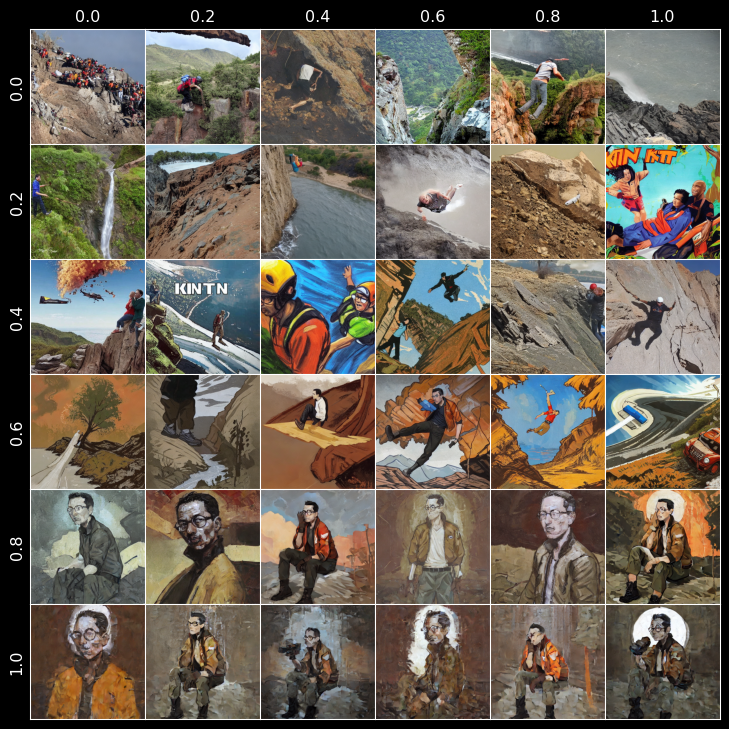

In [12]:
# draw a grid of given images

cols = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
rows = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
img_arrays = [[0 for i in range(6)] for j in range(6)]

for fn in pathlib.Path("/content/gen_imgs").glob("*.png"):
    img = PIL.Image.open(fn)
    lsu, lste, G = map(float, fn.name[3:-4].split(';'))

    if G == 3 and fn.name[:2] == 'fc':

        i = int(lsu // 0.2) if lsu != 1 else 5
        j = int(lste // 0.2) if lste != 1 else 5
        img_arrays[i][j] = img

img_arr = []
for l in img_arrays:
    img_arr += l

plot_img_grid(img_arr, image_size=128, num_cols=6, col_names=cols, row_names=rows)